In [2]:
import os
import pickle
import numpy as np
import datetime
import json
from multiprocessing import Process
from multiprocess import Process

import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16, MobileNetV2, MobileNetV3Small

from models import *
from utils import regression_stats
#from img_utils import data_to_df, preprocess_images, set_gpu, set_cpu

import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2

In [3]:
from utils import data_to_df, preprocess_images, set_gpu, set_cpu
#try reloading the module
IMAGE_WIDTH: int = 224
IMAGE_HEIGHT: int = 224

IMG_WIDTH_448: int = 448
IMG_HEIGHT_448: int = 448


# Load Data
train_1_path: str = "output/train/train_1"
train_2_path: str = "output/train/train_2"
valid_path: str = "output/valid"
test_path: str = "output/test"

# train_1_path: str = "output/train/train_1"
# train_2_path: str = "output/train/train_2"
# valid_path: str = "output/valid"
# test_path: str = "output/test"

train1_df, train2_df, valid_df, test_df = data_to_df(
    [train_1_path, train_2_path, valid_path, test_path], preprocess=True, rm_outliers=True
)

display(train1_df.head())
# Print the lenghts of the datasets
print("Length of datasets:")
print(f"Train 1: {len(train1_df)}")
print(f"Train 2: {len(train2_df)}")
print(f"Valid: {len(valid_df)}")
print(f"Test: {len(test_df)}")

# TODO: Would be better with this format
# train_images: np.array = preprocess_images(
#     train1_df["image_floorplan"], IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
# )


#### Train Set 1 ####
train1_features = train1_df.drop(columns=["image_floorplan", "price"])
train1_images: np.array = preprocess_images(
    train1_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
train1_images_448: np.array = preprocess_images(    
    train1_df, "image_floorplan", IMG_WIDTH_448, IMG_HEIGHT_448, True, False, False
)
train1_prices: np.array = train1_df["price"].values


#### Train Set 2 ####
train2_features = train2_df.drop(columns=["image_floorplan", "price"])
train2_images: np.array = preprocess_images(
    train2_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
train2_images_448: np.array = preprocess_images(
    train2_df, "image_floorplan", IMG_WIDTH_448, IMG_HEIGHT_448, True, False, False
)
train2_prices: np.array = train2_df["price"].values


#### Validation Set ####
valid_features = valid_df.drop(columns=["image_floorplan", "price"])
valid_images: np.array = preprocess_images(
    valid_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
valid_images_448: np.array = preprocess_images(
    valid_df, "image_floorplan", IMG_WIDTH_448, IMG_HEIGHT_448, True, False, False
)
valid_prices: np.array = valid_df["price"].values


#### Test Set ####
test_features = test_df.drop(columns=["image_floorplan", "price"])
test_images: np.array = preprocess_images(
    test_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
test_images_448: np.array = preprocess_images(
    test_df, "image_floorplan", IMG_WIDTH_448, IMG_HEIGHT_448, True, False, False
)

test_prices: np.array = test_df["price"].values

Preprocessing: 100%|██████████| 4/4 [00:00<00:00, 40.41it/s]


Removing outliers...
Datapoints before: 829


Removing outliers: 100%|██████████| 4/4 [00:00<00:00, 254.81it/s]


Datapoints after: 813


,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,postal_avg_sqm_price,lat,lng,image_floorplan
0,64,0,1750000,40,0,2.0,1944.0,1944.0,4,32687.50,55.736966,12.513117,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,37,0,8500000,138,0,4.0,2005.0,2005.0,4,55737.75,55.698085,12.594470,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,40,0,5995000,139,0,5.0,1935.0,2009.0,4,44946.75,55.654361,12.601795,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,36,0,4495000,76,0,3.0,1932.0,1932.0,4,50502.00,55.691502,12.529448,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
5,62,0,2995000,70,0,3.0,1963.0,1963.0,5,36072.25,55.812616,12.469592,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


Length of datasets:
Train 1: 284
Train 2: 286
Valid: 83
Test: 160


In [13]:
from utils import *
def save_model_and_evaluate(
    model: object,
    fit_history: object,
    test_images: np.array,
    test_features: np.array,
    test_prices: np.array,
    model_dir: str,
    model_type:str
):
    if model_type == 'RF':
        print("Saving Model...")
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        with open(f"{model_dir}/model", "wb") as file_pi:
            pickle.dump(model, file_pi)
        test_predictions = model.predict(test_features)
    
    if model_type == "CNN":
        # Save Model
        print("Saving Model...")
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model.save(f"{model_dir}/model")
        # Save Training History
        with open(f"{model_dir}/history", "wb") as file_pi:
            pickle.dump(fit_history.history, file_pi)
        test_predictions = model.predict(test_images)
        #Save Model Architecture
        #plot_model(model, to_file=f"{model_dir}/model_architecture.png", show_shapes=True, show_layer_names=True, show_dtype=True, rankdir="TB", expand_nested=False, dpi=96)
        img = plot_model(model, to_file=f"{model_dir}/architecture.png", show_shapes=True, show_layer_names=True, show_dtype=True, rankdir="TB", expand_nested=False, dpi=96)


    if model_type == 'CNN_RF' or model_type == 'CNN_AE_RF':
        print("Saving Model...")
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        with open(f"{model_dir}/model", "wb") as file_pi:
            pickle.dump(model, file_pi)
        test_predictions = model.predict(test_images, test_features)
        

    # Evaluate Model
    print("Evaluating Model...")
    r2, mae, percentage_error, mse = regression_stats(test_prices, test_predictions)

    try:
        feature_importance = model.feature_importances_
        if model_type == "RF":
            feature_importance = dict(zip(test_features.columns, feature_importance))
    except AttributeError:
        print("Cant find feature_importance")
        feature_importance = None

    # Load existing evaluation data
    evaluation_file_path = f"{model_dir}/evaluation.json"
    evaluation_data = {}
    if os.path.exists(evaluation_file_path):
        with open(evaluation_file_path, "r") as json_file:
            evaluation_data = json.load(json_file)

    # Add new evaluation data
    new_evaluation = {
        "Timestamp": str(datetime.datetime.now()),
        "R2": r2,
        "MAE": mae,
        "Percentage Error": percentage_error,
        "MSE": mse,
        "Feature Importances": (feature_importance),
    }
    evaluation_data[len(evaluation_data)] = new_evaluation

    # Save updated evaluation data
    with open(evaluation_file_path, "w") as json_file:
        json.dump(evaluation_data, json_file, indent=4)

    # Compute median evaluation values from all instances
    r2_values = [evaluation_data[key]["R2"] for key in evaluation_data]
    mae_values = [evaluation_data[key]["MAE"] for key in evaluation_data]
    percentage_error_values = [
        evaluation_data[key]["Percentage Error"] for key in evaluation_data
    ]
    mse_values = [evaluation_data[key]["MSE"] for key in evaluation_data]

    median_evaluation_data = {
        "R2": np.median(r2_values),
        "MAE": np.median(mae_values),
        "Percentage Error": np.median(percentage_error_values),
        "MSE": np.median(mse_values),
    }

    with open(f"{model_dir}/median_evaluation.json", "w") as json_file:
        json.dump(median_evaluation_data, json_file, indent=4)

    print("\nModel Evaluation:")
    print(new_evaluation)
    print("\nMedian Evaluation:")
    print(median_evaluation_data)
    print("Feauter Importance...")
    print(feature_importance)

    # Images (Create or open existing folder)
    if not os.path.exists(f"{model_dir}/images"):
        os.makedirs(f"{model_dir}/images")
    img_dir = f"{model_dir}/images"
    
    save_expected_predicted(test_prices, test_predictions, img_dir)
    save_residuals(test_prices, test_predictions, img_dir)
    
    if model_type == 'CNN':
        print("\nSaving Best and Worst Image Predictions")
        save_worst_best_predictions(model, test_predictions, test_prices, test_images, img_dir)
    
    if model_type != 'CNN': 
        print("\nSaving Feature Importance")
        save_features_importance(feature_importance, img_dir)

    if model_type == 'CNN_AE_RF':
        print("\nSaving Reconstructions")
        save_reconstuctions(model.autoEncoder_, test_predictions, test_prices, test_images, img_dir)

    save_worst_best(test_predictions, test_prices, test_features, model_dir)
    print("\nDone!")


def train_save_model(
    model_func: object,
    args: tuple,
    test_images: np.array,
    test_features: np.array,
    test_prices: np.array,
    model_dir: str,
    use_gpu: bool,
    model_type:str
):
    if use_gpu:
        set_gpu()
    else:
        set_cpu()

    if model_type == "CNN":
        model, fit_history = model_func(*args)
    if model_type == 'RF':
        model = model_func(*args)
        fit_history = None
    if model_type == 'CNN_RF' or model_type == 'CNN_AE_RF':
        model = model_func(*args)
        fit_history = None
    save_model_and_evaluate(model, fit_history, test_images, test_features, test_prices, model_dir, model_type)


def train_save_models(
    model_func: object,
    args: tuple,
    test_images: np.array,
    test_prices: np.array,
    model_dir: str,
    use_gpu: bool,
):
    if use_gpu:
        set_gpu()
    else:
        set_cpu()

    models, fit_histories = model_func(*args)
    for model_idx, (model, fit_history) in enumerate(zip(models, fit_histories)):
        save_model_and_evaluate(
            model, fit_history, test_images, test_prices, f"{model_dir}_{model_idx}"
        )

# Running on CPU

In [4]:
MODELS_PATH: str = "./models"
USE_GPU: bool = False

In [5]:
train2_features = train2_features[['postal_code', 'type', 'size', 'basement_size', 'rooms', 'year_built','year_rebuilt', 'energy_label', 'postal_avg_sqm_price', 'lat', 'lng' ]]

### Naive Guess

In [6]:
mean = test_prices.mean()
mean_Guess = np.full(len(test_prices), mean)
r2, mae, percentage_error, mse = regression_stats(test_prices, mean_Guess)
print(f"Mean Guess R2: {r2}, MAE: {mae}, Percentage Error: {percentage_error}, MSE: {mse}")


Mean Guess R2: 0.0, MAE: 1735519.21875, Percentage Error: 51.359256053020786, MSE: 4822871623085.9375


### Lasso Regression

In [8]:
from models import Lasso_
lasso_model = Lasso_(train2_features, train2_prices)
predictions = lasso_model.predict(test_features)
r2, mae, percentage_error, mse = regression_stats(test_prices, predictions)
print(f"Lasso R2: {r2}, MAE: {mae}, Percentage Error: {percentage_error}, MSE: {mse}")

Lasso R2: 0.7748060360794036, MAE: 722675.3010574252, Percentage Error: 19.005414937968073, MSE: 1086081578282.8832


### RF

In [14]:
from models import RF
TYPE = "RF"
MODEL_NAME: str = "RF"
FUNCTION: object = RF
ARGS: tuple = (
    train2_features,
    train2_prices,
)
train_save_model(FUNCTION, ARGS, test_images, test_features, test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
Saving Model...
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-08 12:00:51.686825', 'R2': 0.8111837603611767, 'MAE': 638624.8125, 'Percentage Error': 15.12351443845183, 'MSE': 910636484131.875, 'Feature Importances': {'postal_code': 0.06795600594749353, 'type': 0.0, 'size': 0.6470570789821838, 'basement_size': 0.0, 'rooms': 0.008711780290090999, 'year_built': 0.04081691180217451, 'year_rebuilt': 0.05026153165005184, 'energy_label': 0.012034084760102187, 'postal_avg_sqm_price': 0.12511146871091067, 'lat': 0.019837462189872118, 'lng': 0.02821367566712042}}

Median Evaluation:
{'R2': 0.8099257752896463, 'MAE': 641675.6875, 'Percentage Error': 15.029167119871515, 'MSE': 916703584635.625}
Feauter Importance...
{'postal_code': 0.06795600594749353, 'type': 0.0, 'size': 0.6470570789821838, 'basement_size': 0.0, 'rooms': 0.008711780290090999, 'year_built': 0.04081691180217451, 'year_rebuilt': 0.05026153165005184, 'energy_label': 0.012034084760102187, 'postal_avg_sqm_p


Saving Feature Importance

Done!


### CNN

In [ ]:
from models import CNN_model1
from keras.applications import MobileNetV3Large

TYPE = 'CNN'
MODEL_NAME: str = "MobileNetV3_Large_1"
FUNCTION: object = CNN_model1
ARGS: tuple = (
    MobileNetV3Large,
    train1_images,
    train1_prices,
    valid_images,
    valid_prices,
    [
    Flatten(),
    Dense(512, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    # BatchNormalization(),
    layers.Dropout(0.2),
    Dense(256, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    layers.Dropout(0.2),
    Dense(128, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    layers.Dropout(0.1),
    Dense(64, activation="relu"),
    Dense(1, activation="linear"),
    ],
)
train = False
if train:
    train_save_model(FUNCTION, ARGS, test_images, test_features, test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)


Setting CPU
Compiling Model
Fitting Model
Epoch 1/100
9/9 [==============================] - 56s 2s/step - loss: 3830072.2500 - mean_absolute_error: 3814672.7500 - val_loss: 4307765.0000 - val_mean_absolute_error: 4302022.0000
Epoch 2/100
9/9 [==============================] - 13s 1s/step - loss: 3818524.0000 - mean_absolute_error: 3812578.2500 - val_loss: 4300476.0000 - val_mean_absolute_error: 4295219.5000
Epoch 3/100
9/9 [==============================] - 12s 1s/step - loss: 3796468.7500 - mean_absolute_error: 3791127.5000 - val_loss: 4245161.0000 - val_mean_absolute_error: 4238672.5000
Epoch 4/100
9/9 [==============================] - 13s 1s/step - loss: 3663740.5000 - mean_absolute_error: 3655459.5000 - val_loss: 3942680.0000 - val_mean_absolute_error: 3931179.5000
Epoch 5/100
9/9 [==============================] - 13s 1s/step - loss: 3048435.5000 - mean_absolute_error: 3033076.5000 - val_loss: 2761275.0000 - val_mean_absolute_error: 2740058.5000
Epoch 6/100
9/9 [================

INFO:tensorflow:Assets written to: ./models/MobileNetV3_Large_1/model/assets


5/5 [==============================] - 17s 931ms/step
Evaluating Model...
Cant find feature_importance

Model Evaluation:
{'Timestamp': '2024-05-02 10:58:37.598544', 'R2': 0.36634960560336016, 'MAE': 1321069.37890625, 'Percentage Error': 55.96587296383744, 'MSE': 3056014506092.7666, 'Feature Importances': None}

Median Evaluation:
{'R2': 0.36634960560336016, 'MAE': 1321069.37890625, 'Percentage Error': 55.96587296383744, 'MSE': 3056014506092.7666}
Feauter Importance...
None

Saving Best and Worst Image Predictions

Done!


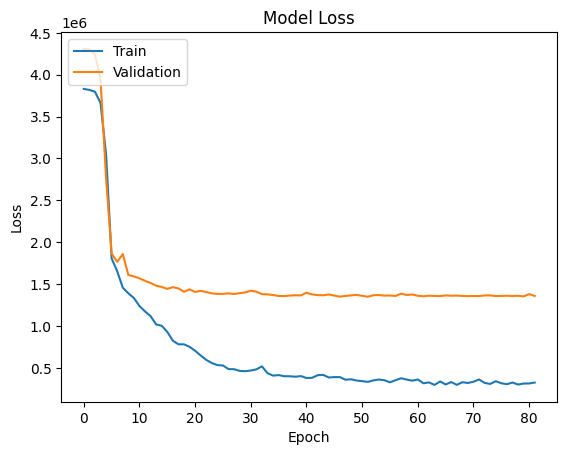

In [ ]:
#load the fit-history 
with open(f"{MODELS_PATH}/MobileNetV3_Large_1/history", "rb") as file_pi:
    history = pickle.load(file_pi)

#plot the history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#Add legend
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(f"{MODELS_PATH}/MobileNetV3_Large/loss.png")
plt.show()
plt.close()


### CNN RF

#### MobileNetV3Large + Random Forrest

In [15]:
MobileNet_CNN = keras.models.load_model(f"{MODELS_PATH}/MobileNetV3_Large_1/model")

In [16]:
from models import CNN_RF_model
TYPE = 'CNN_RF'
MODEL_NAME: str = "MobileNetV3_Large_RF_1"
FUNCTION: object = CNN_RF_model
ARGS: tuple = (
    MobileNet_CNN, # keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    train2_images,
    train2_features,
    train2_prices,
)

train_save_model(FUNCTION, ARGS, test_images, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 16s 1s/step
Saving Model...
5/5 [==============================] - 6s 1s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-08 12:05:25.191150', 'R2': 0.8106362605951949, 'MAE': 655923.4375, 'Percentage Error': 15.589361485155543, 'MSE': 913277005216.875, 'Feature Importances': {'image_predictions': 0.028579270006467795, 'postal_code': 0.06270514485834892, 'type': 0.0, 'size': 0.6403141371761742, 'basement_size': 0.0, 'rooms': 0.009143578656013607, 'year_built': 0.038030734354514865, 'year_rebuilt': 0.04322646401034077, 'energy_label': 0.008922502768470918, 'postal_avg_sqm_price': 0.1280917453391041, 'lat': 0.017620677611489978, 'lng': 0.02336574521907477}}

Median Evaluation:
{'R2': 0.8167331440759821, 'MAE': 644872.6875, 'Percentage Error': 15.384344816548316, 'MSE': 883872518888.125}
Feauter Importance...
{'image_predictions': 0.028579270006467795, 'postal_code': 0.06270514485834892, 'type': 0.0, 'size': 0.6403141371

/usr/local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!


#### VGG16 + Random Forrest

In [17]:
VGG_16_CNN_Img_model = keras.models.load_model(f"{MODELS_PATH}/VGG16")

In [18]:
from models import CNN_RF_model
TYPE = 'CNN_RF'
MODEL_NAME: str = "VGG16_RF"
FUNCTION: object = CNN_RF_model
ARGS: tuple = (
    VGG_16_CNN_Img_model, 
    train2_images_448,
    train2_features,
    train2_prices,
)

train_save_model(FUNCTION, ARGS, test_images_448, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 246s 27s/step
Saving Model...
5/5 [==============================] - 160s 33s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-08 12:18:22.957648', 'R2': 0.7962986021061887, 'MAE': 665518.625, 'Percentage Error': 15.510396326684923, 'MSE': 982425691485.0, 'Feature Importances': {'image_predictions': 0.04768586402086617, 'postal_code': 0.06428915640659431, 'type': 0.0, 'size': 0.6316508521321514, 'basement_size': 0.0, 'rooms': 0.007436734794938596, 'year_built': 0.028666150125535236, 'year_rebuilt': 0.04613555310360441, 'energy_label': 0.006896190554116371, 'postal_avg_sqm_price': 0.12633183964527822, 'lat': 0.01709163876180232, 'lng': 0.023816020455112857}}

Median Evaluation:
{'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625}
Feauter Importance...
{'image_predictions': 0.04768586402086617, 'postal_code': 0.06428915640659431, 'type': 0.0, 'size': 0.631650852

/usr/local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!


#### EfficientNet + Random Forret

In [19]:
EfficientNetB3_CNN_Img_model = keras.models.load_model(f"{MODELS_PATH}/EfficientNetB3")

In [20]:
from models import CNN_RF_model
TYPE = 'CNN_RF'
MODEL_NAME: str = "EfficientNetB3_RF"
FUNCTION: object = CNN_RF_model
ARGS: tuple = (
    EfficientNetB3_CNN_Img_model, # keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    train2_images_448,
    train2_features,
    train2_prices,
)

train_save_model(FUNCTION, ARGS, test_images_448, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 115s 12s/step
Saving Model...
5/5 [==============================] - 62s 13s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-08 12:29:38.940672', 'R2': 0.8156752517691555, 'MAE': 638786.25, 'Percentage Error': 15.134669670055558, 'MSE': 888974597675.0, 'Feature Importances': {'image_predictions': 0.022499112681625386, 'postal_code': 0.05496748094444457, 'type': 0.0, 'size': 0.6527053983114652, 'basement_size': 0.0, 'rooms': 0.008398107293859416, 'year_built': 0.034855919958884866, 'year_rebuilt': 0.052884199327165406, 'energy_label': 0.011011115919470215, 'postal_avg_sqm_price': 0.12140367540213437, 'lat': 0.016794840801027687, 'lng': 0.024480149359922824}}

Median Evaluation:
{'R2': 0.8151244559656948, 'MAE': 639444.125, 'Percentage Error': 15.06637209161174, 'MSE': 891631015125.625}
Feauter Importance...
{'image_predictions': 0.022499112681625386, 'postal_code': 0.05496748094444457, 'type': 0.0, 'size': 0.652705398

/usr/local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!


### CNN + AE + RF

In [22]:
from models import autoEncoder
try: 
  AE_224 = keras.models.load_model(f"{MODELS_PATH}/AE_224")
except:  
  AE_224 = autoEncoder(train1_images, latent_dim=128)
  #AE_224.save_weights(f"{MODELS_PATH}/AE_224")

Epoch 1/30
9/9 [==============================] - 36s 3s/step - loss: 50635.2656
Epoch 2/30
9/9 [==============================] - 28s 3s/step - loss: 32928.7891
Epoch 3/30
9/9 [==============================] - 23s 3s/step - loss: 12377.5723
Epoch 4/30
9/9 [==============================] - 23s 3s/step - loss: 6986.9189
Epoch 5/30
9/9 [==============================] - 22s 2s/step - loss: 4853.6997
Epoch 6/30
9/9 [==============================] - 22s 2s/step - loss: 4044.4265
Epoch 7/30
9/9 [==============================] - 22s 2s/step - loss: 3687.7542
Epoch 8/30
9/9 [==============================] - 22s 2s/step - loss: 3456.3247
Epoch 9/30
9/9 [==============================] - 23s 2s/step - loss: 3320.1707
Epoch 10/30
9/9 [==============================] - 24s 3s/step - loss: 3194.8069
Epoch 11/30
9/9 [==============================] - 23s 3s/step - loss: 3100.9272
Epoch 12/30
9/9 [==============================] - 23s 3s/step - loss: 3022.4775
Epoch 13/30
9/9 [=================

In [23]:
try: 
  AE_448 = keras.models.load_model(f"{MODELS_PATH}/AE_448")

except:
  AE_448 = autoEncoder(train1_images_448, latent_dim=128)
  #AE_448.save(f"{MODELS_PATH}/AE_448")

Epoch 1/30
9/9 [==============================] - 97s 10s/step - loss: 53250.0430
Epoch 2/30
9/9 [==============================] - 90s 10s/step - loss: 25345.6621
Epoch 3/30
9/9 [==============================] - 93s 10s/step - loss: 8799.7637
Epoch 4/30
9/9 [==============================] - 94s 10s/step - loss: 5174.7476
Epoch 5/30
9/9 [==============================] - 89s 10s/step - loss: 3926.0344
Epoch 6/30
9/9 [==============================] - 87s 10s/step - loss: 3491.8301
Epoch 7/30
9/9 [==============================] - 87s 10s/step - loss: 3270.7209
Epoch 8/30
9/9 [==============================] - 88s 10s/step - loss: 3161.5852
Epoch 9/30
9/9 [==============================] - 88s 10s/step - loss: 3063.3430
Epoch 10/30
9/9 [==============================] - 89s 10s/step - loss: 2995.0369
Epoch 11/30
9/9 [==============================] - 89s 10s/step - loss: 2948.1760
Epoch 12/30
9/9 [==============================] - 522s 64s/step - loss: 2903.5771
Epoch 13/30
9/9 [=====

#### MobileNet_AE_RF

In [24]:
from models import CNN_AE_RF_model
#img_model =  keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
TYPE = 'CNN_AE_RF'
MODEL_NAME: str = "MobileNetV3_AE_RF"
FUNCTION: object = CNN_AE_RF_model
ARGS: tuple = (
    MobileNet_CNN, #keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    AE_224, #Or none for training it from scratch
    train2_images,
    train2_features,
    train2_prices,
)
train_save_model(FUNCTION, ARGS, test_images, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 9s 893ms/step
Saving Model...
5/5 [==============================] - 4s 824ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-08 14:08:27.507669', 'R2': 0.8103267692545525, 'MAE': 660955.875, 'Percentage Error': 15.83408620848421, 'MSE': 914769642221.25, 'Feature Importances': {'image_predictions': 0.029841381497127988, 'reconstruction_error': 0.02099033927198016, 'postal_code': 0.06275568167906503, 'type': 0.0, 'size': 0.6422423008900986, 'basement_size': 0.0, 'rooms': 0.006214734990733328, 'year_built': 0.03288740810886502, 'year_rebuilt': 0.04419304932771166, 'energy_label': 0.007737989162258596, 'postal_avg_sqm_price': 0.11622439185900107, 'lat': 0.015188287785021664, 'lng': 0.021724435428136922}}

Median Evaluation:
{'R2': 0.8104093489193249, 'MAE': 649301.5, 'Percentage Error': 15.528704712741698, 'MSE': 914371371099.375}
Feauter Importance...
{'image_predictions': 0.029841381497127988, 'reconstruction_error': 

/usr/local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 2s 474ms/step
[ 30  41  18 136 124 147  27  54 101 107]
[ 53  50  16   2  43  49 130  98 135  44]
1/1 [==============================] - 0s 77ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 65ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 58ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 60ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 86ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 99ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 76ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 84ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 66ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 64ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!


#### VGG16_AE_RF

In [25]:
from models import CNN_AE_RF_model
#img_model =  keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
TYPE = 'CNN_AE_RF'
MODEL_NAME: str = "VGG16_AE_RF"
FUNCTION: object = CNN_AE_RF_model
ARGS: tuple = (
    VGG_16_CNN_Img_model, #keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    AE_448, #Or none for training it from scratch
    train2_images_448,
    train2_features,
    train2_prices,
)

train_save_model(FUNCTION, ARGS, test_images_448, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 182s 20s/step
Saving Model...
5/5 [==============================] - 113s 22s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-08 14:15:40.759040', 'R2': 0.8134347354262519, 'MAE': 648459.0, 'Percentage Error': 15.426771864682271, 'MSE': 899780320366.25, 'Feature Importances': {'image_predictions': 0.04008425439092015, 'reconstruction_error': 0.02405650650942768, 'postal_code': 0.06068774792770994, 'type': 0.0, 'size': 0.6208589538564752, 'basement_size': 0.0, 'rooms': 0.007062450782385501, 'year_built': 0.0353408880793789, 'year_rebuilt': 0.051546349022242095, 'energy_label': 0.005561381466552685, 'postal_avg_sqm_price': 0.1195944534942327, 'lat': 0.014306396081710441, 'lng': 0.0209006183889647}}

Median Evaluation:
{'R2': 0.8132266007428985, 'MAE': 648950.0625, 'Percentage Error': 15.513697755852446, 'MSE': 900784127224.375}
Feauter Importance...
{'image_predictions': 0.04008425439092015, 'reconstruction_error': 0.0

/usr/local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 9s 2s/step
[ 65  30  41 151  18  54 118  76 122  69]
[ 53  50   2 102 140 135  43 123 100  13]
1/1 [==============================] - 0s 153ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 208ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 171ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 126ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 106ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 112ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 112ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 112ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 98ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 140ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 101ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 125ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 136ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 164ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 96ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 312ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 120ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 112ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!


#### EfficientNet + RF + Features

In [27]:
from models import CNN_AE_RF_model
#img_model =  keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
TYPE = 'CNN_AE_RF'
MODEL_NAME: str = "EfficientNetB3_AE_RF"
FUNCTION: object = CNN_AE_RF_model
ARGS: tuple = (
    EfficientNetB3_CNN_Img_model, #keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    AE_448, #Or none for training it from scratch
    train2_images_448,
    train2_features,
    train2_prices,
)

train_save_model(FUNCTION, ARGS, test_images_448, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 94s 10s/step
Saving Model...
5/5 [==============================] - 56s 11s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-08 14:22:49.988912', 'R2': 0.8175666961924237, 'MAE': 651748.4375, 'Percentage Error': 15.71700800905701, 'MSE': 879852404039.375, 'Feature Importances': {'image_predictions': 0.02026997366898531, 'reconstruction_error': 0.027994041904510172, 'postal_code': 0.05887908816885933, 'type': 0.0, 'size': 0.6530171608507535, 'basement_size': 0.0, 'rooms': 0.009601164576228133, 'year_built': 0.028626681228918614, 'year_rebuilt': 0.04257901649816746, 'energy_label': 0.006473686056324984, 'postal_avg_sqm_price': 0.11560300493015527, 'lat': 0.016630748175368634, 'lng': 0.020325433941728702}}

Median Evaluation:
{'R2': 0.8164416555204096, 'MAE': 645174.8125, 'Percentage Error': 15.467928614378087, 'MSE': 885278330771.25}
Feauter Importance...
{'image_predictions': 0.02026997366898531, 'reconstruction_error'

/usr/local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 8s 2s/step
[ 65  30  41 151  18  54 118  76 122  69]
[ 53  50   2 102 140 135  43 123 100  13]
1/1 [==============================] - 0s 112ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 113ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 107ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 104ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 106ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 225ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 172ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 115ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 135ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 127ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 142ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 110ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 136ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 93ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 148ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 110ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 120ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 106ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!


### N-CNN

In [ ]:
from models import N_CNN_RF_model
from keras.applications import MobileNetV3Small
TYPE = 'CNN_RF'
MODEL_NAME: str = "N_CNN_MobileNetV2_RF"
FUNCTION: object = N_CNN_RF_model
ARGS: tuple = (
    4,
    MobileNetV3Small,
    np.concatenate((train1_images, train2_images), axis=0),
    pd.concat((train1_features, train2_features), axis=0),

    np.concatenate((train1_prices, train2_prices), axis=0),
)
train_save_model(FUNCTION, ARGS, test_images, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

In [ ]:
n = 4
from models import N_CNN_RF_V2
from keras.applications import MobileNetV3Small
custom_layers = [
    #Type 1
    Flatten(),
    Dense(512, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    # BatchNormalization(),
    layers.Dropout(0.2),
    Dense(256, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    layers.Dropout(0.2),
    Dense(128, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    layers.Dropout(0.1),
    Dense(64, activation="relu"),
    Dense(1, activation="linear"),
    ]

N_CNN_RF_V2_model = N_CNN_RF_V2(n, MobileNetV3Small, custom_layers)
N_CNN_RF_V2_model.fit(np.concatenate((train1_images, train2_images), axis=0), 
                      pd.concat((train1_features, train2_features), axis=0), 
                      np.concatenate((train1_prices, train2_prices), axis=0),
                      valid_images, 
                      valid_prices,
                      n) 

Training model  0
Number of Training Images 427
Mean of Training Images 3760796.2529274006
Compiling Model
Fitting Model
Epoch 1/100
14/14 [==============================] - 29s 972ms/step - loss: 3771485.0000 - mean_absolute_error: 3760770.7500 - val_loss: 4306321.5000 - val_mean_absolute_error: 4302275.0000
Epoch 2/100
14/14 [==============================] - 9s 636ms/step - loss: 3762207.7500 - mean_absolute_error: 3758456.0000 - val_loss: 4294137.0000 - val_mean_absolute_error: 4290513.5000
Epoch 3/100
14/14 [==============================] - 9s 649ms/step - loss: 3691666.5000 - mean_absolute_error: 3685977.7500 - val_loss: 4040676.2500 - val_mean_absolute_error: 4030434.2500
Epoch 4/100
14/14 [==============================] - 9s 640ms/step - loss: 2845275.7500 - mean_absolute_error: 2827626.5000 - val_loss: 2073299.2500 - val_mean_absolute_error: 2043941.2500
Epoch 5/100
14/14 [==============================] - 9s 645ms/step - loss: 1577538.2500 - mean_absolute_error: 1544202.250

Training model  0
Number of Training Images 427
Mean of Training Images 3760796.2529274006
Number of datapoints in validation set 143
Mean of validation set 3835531.4685314684
Compiling Model
Fitting Model
Epoch 1/100
14/14 [==============================] - 27s 973ms/step - loss: 3771481.0000 - mean_absolute_error: 3760765.0000 - val_loss: 3839358.7500 - val_mean_absolute_error: 3835299.0000
Epoch 2/100
14/14 [==============================] - 10s 726ms/step - loss: 3761812.5000 - mean_absolute_error: 3758008.2500 - val_loss: 3825120.2500 - val_mean_absolute_error: 3821390.2500
Epoch 3/100
14/14 [==============================] - 11s 771ms/step - loss: 3686866.7500 - mean_absolute_error: 3681084.2500 - val_loss: 3559687.2500 - val_mean_absolute_error: 3549439.0000
Epoch 4/100
14/14 [==============================] - 10s 736ms/step - loss: 2838282.7500 - mean_absolute_error: 2821121.0000 - val_loss: 1658022.5000 - val_mean_absolute_error: 1629887.0000
Epoch 5/100
14/14 [==============================] - 10s 738ms/step - loss: 1636304.6250 - mean_absolute_error: 1603869.8750 - val_loss: 1556243.7500 - val_mean_absolute_error: 1524349.6250
Epoch 6/100
14/14 [==============================] - 10s 747ms/step - loss: 1473385.2500 - mean_absolute_error: 1442229.3750 - val_loss: 1508453.8750 - val_mean_absolute_error: 1475986.1250
Epoch 7/100
14/14 [==============================] - 10s 721ms/step - loss: 1406986.2500 - mean_absolute_error: 1373288.8750 - val_loss: 1457318.1250 - val_mean_absolute_error: 1423618.2500
Epoch 8/100
14/14 [==============================] - 11s 765ms/step - loss: 1308593.0000 - mean_absolute_error: 1274780.8750 - val_loss: 1423733.5000 - val_mean_absolute_error: 1389396.3750
Epoch 9/100
14/14 [==============================] - 10s 723ms/step - loss: 1271124.5000 - mean_absolute_error: 1235551.8750 - val_loss: 1383650.6250 - val_mean_absolute_error: 1347186.3750
Epoch 10/100
14/14 [==============================] - 10s 717ms/step - loss: 1222743.1250 - mean_absolute_error: 1185535.3750 - val_loss: 1366021.8750 - val_mean_absolute_error: 1327473.3750
Epoch 11/100
14/14 [==============================] - 11s 769ms/step - loss: 1183205.8750 - mean_absolute_error: 1143846.3750 - val_loss: 1333733.8750 - val_mean_absolute_error: 1293136.5000
Epoch 12/100
14/14 [==============================] - 10s 754ms/step - loss: 1114573.2500 - mean_absolute_error: 1072733.2500 - val_loss: 1325493.5000 - val_mean_absolute_error: 1282597.7500
Epoch 13/100
14/14 [==============================] - 11s 793ms/step - loss: 1063411.8750 - mean_absolute_error: 1019350.1250 - val_loss: 1316382.5000 - val_mean_absolute_error: 1270909.5000
Epoch 14/100
14/14 [==============================] - 10s 723ms/step - loss: 1014580.1875 - mean_absolute_error: 968065.6250 - val_loss: 1301035.1250 - val_mean_absolute_error: 1253193.3750
Epoch 15/100
14/14 [==============================] - 10s 718ms/step - loss: 954471.0625 - mean_absolute_error: 905561.1875 - val_loss: 1330987.3750 - val_mean_absolute_error: 1280688.8750
Epoch 16/100
14/14 [==============================] - 10s 747ms/step - loss: 887342.7500 - mean_absolute_error: 836073.7500 - val_loss: 1287097.6250 - val_mean_absolute_error: 1234655.1250
Epoch 17/100
14/14 [==============================] - 10s 748ms/step - loss: 816783.5625 - mean_absolute_error: 763360.3125 - val_loss: 1286014.8750 - val_mean_absolute_error: 1231537.8750
Epoch 18/100
14/14 [==============================] - 10s 753ms/step - loss: 742714.8750 - mean_absolute_error: 687325.1250 - val_loss: 1266559.7500 - val_mean_absolute_error: 1210229.0000
Epoch 19/100
14/14 [==============================] - 10s 713ms/step - loss: 736329.0625 - mean_absolute_error: 679155.8750 - val_loss: 1268679.3750 - val_mean_absolute_error: 1210771.2500
Epoch 20/100
14/14 [==============================] - 10s 754ms/step - loss: 671491.3125 - mean_absolute_error: 613068.6875 - val_loss: 1263264.1250 - val_mean_absolute_error: 1204199.8750
Epoch 21/100
14/14 [==============================] - 10s 742ms/step - loss: 650520.0625 - mean_absolute_error: 590837.5000 - val_loss: 1346535.0000 - val_mean_absolute_error: 1286035.2500
Epoch 22/100
14/14 [==============================] - 10s 726ms/step - loss: 639740.1250 - mean_absolute_error: 578891.1875 - val_loss: 1252580.5000 - val_mean_absolute_error: 1191249.3750
Epoch 23/100
14/14 [==============================] - 11s 778ms/step - loss: 596105.5625 - mean_absolute_error: 534419.4375 - val_loss: 1247844.6250 - val_mean_absolute_error: 1185914.6250
Epoch 24/100
14/14 [==============================] - 11s 781ms/step - loss: 570844.9375 - mean_absolute_error: 508578.2188 - val_loss: 1300427.5000 - val_mean_absolute_error: 1237714.1250
Epoch 25/100
14/14 [==============================] - 11s 765ms/step - loss: 592623.1875 - mean_absolute_error: 529617.3750 - val_loss: 1292063.7500 - val_mean_absolute_error: 1228672.8750
Epoch 26/100
14/14 [==============================] - 11s 786ms/step - loss: 579482.8750 - mean_absolute_error: 515860.0000 - val_loss: 1245209.5000 - val_mean_absolute_error: 1181419.0000
Epoch 27/100
14/14 [==============================] - 10s 758ms/step - loss: 532907.0000 - mean_absolute_error: 468937.0312 - val_loss: 1283088.5000 - val_mean_absolute_error: 1218842.5000
Epoch 28/100
14/14 [==============================] - 11s 777ms/step - loss: 503778.2500 - mean_absolute_error: 439421.0625 - val_loss: 1255359.0000 - val_mean_absolute_error: 1190909.5000
Epoch 29/100
14/14 [==============================] - 11s 801ms/step - loss: 497025.1875 - mean_absolute_error: 432397.0000 - val_loss: 1246495.8750 - val_mean_absolute_error: 1181667.3750
Epoch 30/100
14/14 [==============================] - 13s 925ms/step - loss: 492272.1562 - mean_absolute_error: 427320.2500 - val_loss: 1292626.2500 - val_mean_absolute_error: 1227380.3750
Epoch 31/100
14/14 [==============================] - 13s 937ms/step - loss: 476540.0312 - mean_absolute_error: 411072.6875 - val_loss: 1254260.8750 - val_mean_absolute_error: 1188502.1250
Epoch 32/100
14/14 [==============================] - 13s 909ms/step - loss: 430046.0938 - mean_absolute_error: 364193.3438 - val_loss: 1243737.0000 - val_mean_absolute_error: 1177826.8750
Epoch 33/100
14/14 [==============================] - 13s 938ms/step - loss: 423618.0000 - mean_absolute_error: 357672.6562 - val_loss: 1286808.3750 - val_mean_absolute_error: 1220697.6250
Epoch 34/100
14/14 [==============================] - 10s 748ms/step - loss: 458031.0000 - mean_absolute_error: 391756.8438 - val_loss: 1244549.7500 - val_mean_absolute_error: 1178229.7500
Epoch 35/100
14/14 [==============================] - 10s 736ms/step - loss: 411383.5625 - mean_absolute_error: 344965.6875 - val_loss: 1257815.1250 - val_mean_absolute_error: 1191306.5000
Epoch 36/100
14/14 [==============================] - 11s 780ms/step - loss: 399189.7812 - mean_absolute_error: 332589.7500 - val_loss: 1260717.6250 - val_mean_absolute_error: 1194028.2500
Epoch 37/100
14/14 [==============================] - 10s 752ms/step - loss: 379250.8750 - mean_absolute_error: 312587.8438 - val_loss: 1297644.2500 - val_mean_absolute_error: 1231057.3750
Epoch 38/100
14/14 [==============================] - 10s 762ms/step - loss: 429155.6875 - mean_absolute_error: 362668.1250 - val_loss: 1246969.1250 - val_mean_absolute_error: 1180531.3750
Epoch 39/100
14/14 [==============================] - 11s 780ms/step - loss: 395845.7812 - mean_absolute_error: 329274.2188 - val_loss: 1252589.3750 - val_mean_absolute_error: 1185967.7500
Epoch 40/100
14/14 [==============================] - 10s 738ms/step - loss: 375097.9375 - mean_absolute_error: 308552.1562 - val_loss: 1273065.2500 - val_mean_absolute_error: 1206590.6250
Epoch 41/100
14/14 [==============================] - 10s 730ms/step - loss: 381443.5000 - mean_absolute_error: 314977.1562 - val_loss: 1266748.1250 - val_mean_absolute_error: 1200368.3750
Epoch 42/100
14/14 [==============================] - 11s 798ms/step - loss: 366576.8750 - mean_absolute_error: 300192.5000 - val_loss: 1300232.0000 - val_mean_absolute_error: 1233765.2500
Epoch 43/100
14/14 [==============================] - 11s 760ms/step - loss: 395714.0938 - mean_absolute_error: 329286.3750 - val_loss: 1235664.5000 - val_mean_absolute_error: 1169282.5000
Epoch 44/100
14/14 [==============================] - 11s 810ms/step - loss: 368203.0625 - mean_absolute_error: 301808.8438 - val_loss: 1279621.7500 - val_mean_absolute_error: 1213236.5000
Epoch 45/100
14/14 [==============================] - 11s 776ms/step - loss: 360520.0312 - mean_absolute_error: 294195.4062 - val_loss: 1232331.6250 - val_mean_absolute_error: 1166127.0000
Epoch 46/100
14/14 [==============================] - 11s 785ms/step - loss: 365291.1250 - mean_absolute_error: 299031.4062 - val_loss: 1257216.0000 - val_mean_absolute_error: 1190978.6250
Epoch 47/100
14/14 [==============================] - 11s 789ms/step - loss: 355305.0000 - mean_absolute_error: 289092.2812 - val_loss: 1248196.7500 - val_mean_absolute_error: 1182100.7500
Epoch 48/100
14/14 [==============================] - 11s 767ms/step - loss: 346215.3750 - mean_absolute_error: 280084.2500 - val_loss: 1260921.6250 - val_mean_absolute_error: 1194794.8750
Epoch 49/100
14/14 [==============================] - 11s 771ms/step - loss: 363688.4062 - mean_absolute_error: 297673.6250 - val_loss: 1237279.2500 - val_mean_absolute_error: 1171405.2500
Epoch 50/100
14/14 [==============================] - 11s 796ms/step - loss: 382861.2500 - mean_absolute_error: 316958.2500 - val_loss: 1259356.2500 - val_mean_absolute_error: 1193549.6250
Epoch 51/100
14/14 [==============================] - 11s 825ms/step - loss: 334907.2188 - mean_absolute_error: 269145.2812 - val_loss: 1292151.2500 - val_mean_absolute_error: 1226367.1250
Epoch 52/100
14/14 [==============================] - 10s 740ms/step - loss: 354881.3125 - mean_absolute_error: 289141.1250 - val_loss: 1259421.7500 - val_mean_absolute_error: 1193741.3750
Epoch 53/100
14/14 [==============================] - 11s 830ms/step - loss: 331186.0938 - mean_absolute_error: 265412.1562 - val_loss: 1271442.7500 - val_mean_absolute_error: 1205659.3750
Epoch 54/100
14/14 [==============================] - 11s 770ms/step - loss: 328867.0000 - mean_absolute_error: 263151.7500 - val_loss: 1245310.8750 - val_mean_absolute_error: 1179696.1250
Epoch 55/100
14/14 [==============================] - 11s 782ms/step - loss: 351840.5625 - mean_absolute_error: 286254.0938 - val_loss: 1251319.6250 - val_mean_absolute_error: 1185866.1250
Epoch 56/100
14/14 [==============================] - 11s 805ms/step - loss: 383898.7500 - mean_absolute_error: 318514.7812 - val_loss: 1310284.8750 - val_mean_absolute_error: 1244911.2500
Epoch 57/100
14/14 [==============================] - 11s 775ms/step - loss: 356631.4062 - mean_absolute_error: 291294.1562 - val_loss: 1247103.0000 - val_mean_absolute_error: 1181780.0000
Epoch 58/100
14/14 [==============================] - 11s 772ms/step - loss: 337087.7812 - mean_absolute_error: 271735.6562 - val_loss: 1265855.0000 - val_mean_absolute_error: 1200528.7500
Epoch 59/100
14/14 [==============================] - 11s 782ms/step - loss: 318576.4375 - mean_absolute_error: 253335.1719 - val_loss: 1263646.0000 - val_mean_absolute_error: 1198521.3750
Epoch 60/100
14/14 [==============================] - 11s 764ms/step - loss: 323287.3125 - mean_absolute_error: 258252.6250 - val_loss: 1245694.0000 - val_mean_absolute_error: 1180704.3750
Epoch 61/100
14/14 [==============================] - 11s 804ms/step - loss: 348889.0312 - mean_absolute_error: 283962.6562 - val_loss: 1239749.7500 - val_mean_absolute_error: 1174917.8750
Epoch 62/100
14/14 [==============================] - 11s 776ms/step - loss: 326982.2812 - mean_absolute_error: 262091.1719 - val_loss: 1281785.7500 - val_mean_absolute_error: 1216906.0000
Epoch 63/100
14/14 [==============================] - 11s 830ms/step - loss: 324863.1875 - mean_absolute_error: 260018.8281 - val_loss: 1261624.3750 - val_mean_absolute_error: 1196771.1250
Epoch 64/100
14/14 [==============================] - 11s 816ms/step - loss: 322463.4688 - mean_absolute_error: 257662.7031 - val_loss: 1241012.3750 - val_mean_absolute_error: 1176404.7500
Epoch 65/100
14/14 [==============================] - 11s 787ms/step - loss: 319880.5312 - mean_absolute_error: 255381.2031 - val_loss: 1267117.0000 - val_mean_absolute_error: 1202672.6250
Epoch 66/100
14/14 [==============================] - 11s 778ms/step - loss: 311373.0938 - mean_absolute_error: 246887.9219 - val_loss: 1242858.0000 - val_mean_absolute_error: 1178321.2500
Epoch 67/100
14/14 [==============================] - 11s 779ms/step - loss: 306303.1875 - mean_absolute_error: 241754.8125 - val_loss: 1242387.8750 - val_mean_absolute_error: 1177975.7500
Epoch 68/100
14/14 [==============================] - 11s 795ms/step - loss: 313506.1250 - mean_absolute_error: 249170.7969 - val_loss: 1222415.5000 - val_mean_absolute_error: 1158215.1250
Epoch 69/100
14/14 [==============================] - 11s 812ms/step - loss: 337615.8750 - mean_absolute_error: 273357.0000 - val_loss: 1250585.2500 - val_mean_absolute_error: 1186289.2500
Epoch 70/100
14/14 [==============================] - 11s 769ms/step - loss: 324104.5000 - mean_absolute_error: 259820.4531 - val_loss: 1294557.8750 - val_mean_absolute_error: 1230264.3750
Epoch 71/100
14/14 [==============================] - 11s 787ms/step - loss: 323181.7500 - mean_absolute_error: 258993.7969 - val_loss: 1275154.1250 - val_mean_absolute_error: 1210978.0000
Epoch 72/100
14/14 [==============================] - 11s 825ms/step - loss: 301030.3438 - mean_absolute_error: 236971.7500 - val_loss: 1250821.7500 - val_mean_absolute_error: 1186958.0000
Epoch 73/100
14/14 [==============================] - 10s 745ms/step - loss: 326586.5000 - mean_absolute_error: 262677.8750 - val_loss: 1263211.6250 - val_mean_absolute_error: 1199281.6250
Epoch 74/100
14/14 [==============================] - 11s 771ms/step - loss: 326460.5938 - mean_absolute_error: 262542.9375 - val_loss: 1298798.1250 - val_mean_absolute_error: 1234962.3750
Epoch 75/100
14/14 [==============================] - 11s 781ms/step - loss: 311386.7188 - mean_absolute_error: 247644.7188 - val_loss: 1242751.6250 - val_mean_absolute_error: 1179128.3750
Epoch 76/100
14/14 [==============================] - 10s 746ms/step - loss: 321069.8750 - mean_absolute_error: 257523.7344 - val_loss: 1240065.3750 - val_mean_absolute_error: 1176625.6250
Epoch 77/100
14/14 [==============================] - 11s 780ms/step - loss: 322289.5625 - mean_absolute_error: 258819.2188 - val_loss: 1264081.1250 - val_mean_absolute_error: 1200568.3750
Epoch 78/100
14/14 [==============================] - 11s 783ms/step - loss: 317987.5938 - mean_absolute_error: 254463.3438 - val_loss: 1250580.7500 - val_mean_absolute_error: 1187135.5000
Epoch 79/100
14/14 [==============================] - 10s 757ms/step - loss: 287897.8750 - mean_absolute_error: 224478.0000 - val_loss: 1261099.1250 - val_mean_absolute_error: 1197714.6250
Epoch 80/100
14/14 [==============================] - 10s 730ms/step - loss: 294136.3125 - mean_absolute_error: 230865.8750 - val_loss: 1254437.7500 - val_mean_absolute_error: 1191382.3750
Epoch 81/100
14/14 [==============================] - 10s 728ms/step - loss: 308186.6875 - mean_absolute_error: 245196.2969 - val_loss: 1267052.3750 - val_mean_absolute_error: 1204133.1250
Epoch 82/100
14/14 [==============================] - 11s 763ms/step - loss: 279651.2812 - mean_absolute_error: 216777.9062 - val_loss: 1266742.0000 - val_mean_absolute_error: 1203859.6250
Epoch 83/100
14/14 [==============================] - 10s 733ms/step - loss: 296017.0625 - mean_absolute_error: 233116.3281 - val_loss: 1258912.5000 - val_mean_absolute_error: 1196070.1250
Epoch 84/100
14/14 [==============================] - 10s 746ms/step - loss: 314549.2500 - mean_absolute_error: 251756.7344 - val_loss: 1250288.7500 - val_mean_absolute_error: 1187663.2500
Epoch 85/100
14/14 [==============================] - 10s 718ms/step - loss: 318533.6250 - mean_absolute_error: 255896.3750 - val_loss: 1237992.7500 - val_mean_absolute_error: 1175379.1250
Epoch 86/100
14/14 [==============================] - 10s 723ms/step - loss: 314762.7188 - mean_absolute_error: 252144.1562 - val_loss: 1259106.2500 - val_mean_absolute_error: 1196605.3750
Epoch 87/100
14/14 [==============================] - 10s 735ms/step - loss: 300351.8438 - mean_absolute_error: 237903.6875 - val_loss: 1225054.6250 - val_mean_absolute_error: 1162680.3750
Epoch 88/100
14/14 [==============================] - 10s 712ms/step - loss: 321877.0625 - mean_absolute_error: 259487.6250 - val_loss: 1255012.3750 - val_mean_absolute_error: 1192652.0000
Epoch 89/100
14/14 [==============================] - 10s 760ms/step - loss: 285088.1250 - mean_absolute_error: 222752.1250 - val_loss: 1262609.6250 - val_mean_absolute_error: 1200358.2500
Epoch 90/100
14/14 [==============================] - 10s 719ms/step - loss: 295900.5000 - mean_absolute_error: 233698.4531 - val_loss: 1240085.5000 - val_mean_absolute_error: 1177952.0000
Epoch 91/100
14/14 [==============================] - 10s 703ms/step - loss: 267434.9062 - mean_absolute_error: 205324.9531 - val_loss: 1262486.2500 - val_mean_absolute_error: 1200449.0000
Epoch 92/100
14/14 [==============================] - 10s 742ms/step - loss: 285915.5312 - mean_absolute_error: 223881.3750 - val_loss: 1250668.2500 - val_mean_absolute_error: 1188660.6250
Epoch 93/100
14/14 [==============================] - 10s 723ms/step - loss: 301828.7812 - mean_absolute_error: 239796.5469 - val_loss: 1261651.5000 - val_mean_absolute_error: 1199695.8750
Epoch 94/100
14/14 [==============================] - 10s 717ms/step - loss: 282270.9375 - mean_absolute_error: 220450.7344 - val_loss: 1262573.1250 - val_mean_absolute_error: 1200859.8750
Epoch 95/100
14/14 [==============================] - 11s 809ms/step - loss: 280735.8438 - mean_absolute_error: 219086.7812 - val_loss: 1250342.3750 - val_mean_absolute_error: 1188783.2500
Epoch 96/100
14/14 [==============================] - 10s 713ms/step - loss: 306107.2500 - mean_absolute_error: 244569.5156 - val_loss: 1256175.6250 - val_mean_absolute_error: 1194624.8750
Epoch 97/100
14/14 [==============================] - 10s 735ms/step - loss: 291494.3750 - mean_absolute_error: 229889.8750 - val_loss: 1227363.1250 - val_mean_absolute_error: 1165765.6250
Epoch 98/100
14/14 [==============================] - 11s 769ms/step - loss: 286150.5312 - mean_absolute_error: 224513.2031 - val_loss: 1291472.8750 - val_mean_absolute_error: 1229762.2500
Training model  1
Number of Training Images 427
Mean of Training Images 3775613.5831381734
Number of datapoints in validation set 143
Mean of validation set 3791286.713286713
Compiling Model
Fitting Model
Epoch 1/100
14/14 [==============================] - 30s 991ms/step - loss: 634497.0625 - mean_absolute_error: 570188.3125 - val_loss: 263846.3438 - val_mean_absolute_error: 199507.5625
Epoch 2/100
14/14 [==============================] - 10s 688ms/step - loss: 584605.5625 - mean_absolute_error: 520280.3438 - val_loss: 275108.1250 - val_mean_absolute_error: 210795.4219
Epoch 3/100
14/14 [==============================] - 10s 722ms/step - loss: 570820.7500 - mean_absolute_error: 506430.7188 - val_loss: 232282.9688 - val_mean_absolute_error: 167791.2969
Epoch 4/100
14/14 [==============================] - 10s 723ms/step - loss: 541609.0625 - mean_absolute_error: 476957.7500 - val_loss: 239074.7344 - val_mean_absolute_error: 174200.0312
Epoch 5/100
14/14 [==============================] - 10s 719ms/step - loss: 530905.8750 - mean_absolute_error: 465881.6250 - val_loss: 257326.7344 - val_mean_absolute_error: 192221.0469
Epoch 6/100
14/14 [==============================] - 10s 741ms/step - loss: 499593.9688 - mean_absolute_error: 434436.5938 - val_loss: 245766.3750 - val_mean_absolute_error: 180564.5000
Epoch 7/100
14/14 [==============================] - 10s 702ms/step - loss: 513905.1875 - mean_absolute_error: 448685.5625 - val_loss: 341028.2500 - val_mean_absolute_error: 275794.5938
Epoch 8/100
14/14 [==============================] - 10s 704ms/step - loss: 508872.9062 - mean_absolute_error: 443545.2812 - val_loss: 274793.5000 - val_mean_absolute_error: 209430.2031
Epoch 9/100
14/14 [==============================] - 10s 735ms/step - loss: 487597.6875 - mean_absolute_error: 422173.1250 - val_loss: 277503.0938 - val_mean_absolute_error: 211926.9531
Epoch 10/100
14/14 [==============================] - 10s 695ms/step - loss: 466938.4062 - mean_absolute_error: 401222.0625 - val_loss: 273121.4062 - val_mean_absolute_error: 207335.7344
Epoch 11/100
14/14 [==============================] - 10s 730ms/step - loss: 453883.8438 - mean_absolute_error: 388108.0312 - val_loss: 290870.6875 - val_mean_absolute_error: 225045.0312
Epoch 12/100
14/14 [==============================] - 10s 744ms/step - loss: 456425.2812 - mean_absolute_error: 390520.4688 - val_loss: 308467.6875 - val_mean_absolute_error: 242438.1875
Epoch 13/100
14/14 [==============================] - 10s 703ms/step - loss: 447389.8750 - mean_absolute_error: 381243.5312 - val_loss: 354248.4062 - val_mean_absolute_error: 288002.5938
Epoch 14/100
14/14 [==============================] - 10s 714ms/step - loss: 421026.9688 - mean_absolute_error: 354658.2500 - val_loss: 326652.0312 - val_mean_absolute_error: 260215.1406
Epoch 15/100
14/14 [==============================] - 10s 712ms/step - loss: 432086.3750 - mean_absolute_error: 365637.9688 - val_loss: 330699.3125 - val_mean_absolute_error: 264238.8750
Epoch 16/100
14/14 [==============================] - 10s 738ms/step - loss: 412523.1250 - mean_absolute_error: 346027.8750 - val_loss: 336984.1250 - val_mean_absolute_error: 270456.0625
Epoch 17/100
14/14 [==============================] - 10s 705ms/step - loss: 391339.6250 - mean_absolute_error: 324731.0625 - val_loss: 410780.8750 - val_mean_absolute_error: 344083.8750
Epoch 18/100
14/14 [==============================] - 10s 698ms/step - loss: 408166.8438 - mean_absolute_error: 341349.6250 - val_loss: 365459.0312 - val_mean_absolute_error: 298475.9062
Epoch 19/100
14/14 [==============================] - 10s 720ms/step - loss: 407575.3750 - mean_absolute_error: 340526.5000 - val_loss: 344726.6875 - val_mean_absolute_error: 277647.7812
Epoch 20/100
14/14 [==============================] - 10s 699ms/step - loss: 384631.2812 - mean_absolute_error: 317540.5625 - val_loss: 396153.8438 - val_mean_absolute_error: 329100.6250
Epoch 21/100
14/14 [==============================] - 10s 722ms/step - loss: 375080.5938 - mean_absolute_error: 308053.3125 - val_loss: 359594.0938 - val_mean_absolute_error: 292601.9062
Epoch 22/100
14/14 [==============================] - 10s 719ms/step - loss: 361394.2500 - mean_absolute_error: 294404.5000 - val_loss: 359138.5312 - val_mean_absolute_error: 292158.4375
Epoch 23/100
14/14 [==============================] - 10s 692ms/step - loss: 334352.2500 - mean_absolute_error: 267358.7812 - val_loss: 376115.2188 - val_mean_absolute_error: 309080.1250
Epoch 24/100
14/14 [==============================] - 10s 715ms/step - loss: 357713.7188 - mean_absolute_error: 290687.7812 - val_loss: 403204.3438 - val_mean_absolute_error: 336174.7812
Epoch 25/100
14/14 [==============================] - 10s 721ms/step - loss: 351417.5312 - mean_absolute_error: 284340.6562 - val_loss: 360898.8750 - val_mean_absolute_error: 293797.1875
Epoch 26/100
14/14 [==============================] - 10s 745ms/step - loss: 344657.2812 - mean_absolute_error: 277567.0312 - val_loss: 378740.8750 - val_mean_absolute_error: 311612.0938
Epoch 27/100
14/14 [==============================] - 11s 778ms/step - loss: 339932.1875 - mean_absolute_error: 272792.6875 - val_loss: 404977.9688 - val_mean_absolute_error: 337885.4688
Epoch 28/100
14/14 [==============================] - 11s 804ms/step - loss: 333808.1250 - mean_absolute_error: 266702.4375 - val_loss: 429145.7188 - val_mean_absolute_error: 362089.7188
Epoch 29/100
14/14 [==============================] - 1157s 792ms/step - loss: 318266.7188 - mean_absolute_error: 251209.5000 - val_loss: 408617.5625 - val_mean_absolute_error: 341564.1250
Epoch 30/100
14/14 [==============================] - 961s 74s/step - loss: 322115.9062 - mean_absolute_error: 255104.5625 - val_loss: 430971.9062 - val_mean_absolute_error: 364020.4688
Epoch 31/100
14/14 [==============================] - 7s 486ms/step - loss: 323097.3750 - mean_absolute_error: 256204.4062 - val_loss: 399786.6250 - val_mean_absolute_error: 332997.0938
Epoch 32/100
14/14 [==============================] - 63s 5s/step - loss: 319205.7812 - mean_absolute_error: 252473.8438 - val_loss: 409243.7812 - val_mean_absolute_error: 342530.8125
Epoch 33/100
14/14 [==============================] - 12s 842ms/step - loss: 334843.5000 - mean_absolute_error: 268149.0000 - val_loss: 466733.3438 - val_mean_absolute_error: 400129.7812
Training model  2
Number of Training Images 428
Mean of Training Images 3777661.214953271
Number of datapoints in validation set 142
Mean of validation set 3785225.352112676
Compiling Model
Fitting Model
Epoch 1/100
14/14 [==============================] - 19s 748ms/step - loss: 594444.6875 - mean_absolute_error: 529822.8125 - val_loss: 337849.0000 - val_mean_absolute_error: 273027.4688
Epoch 2/100
14/14 [==============================] - 10s 713ms/step - loss: 574361.1250 - mean_absolute_error: 509517.5938 - val_loss: 225735.3125 - val_mean_absolute_error: 160868.1406
Epoch 3/100
14/14 [==============================] - 11s 785ms/step - loss: 558201.5000 - mean_absolute_error: 493295.1875 - val_loss: 249052.2812 - val_mean_absolute_error: 184058.0781
Epoch 4/100
14/14 [==============================] - 12s 845ms/step - loss: 549148.5000 - mean_absolute_error: 484082.0938 - val_loss: 260870.8125 - val_mean_absolute_error: 195703.4062
Epoch 5/100
14/14 [==============================] - 12s 889ms/step - loss: 517994.4062 - mean_absolute_error: 452749.4688 - val_loss: 240783.6094 - val_mean_absolute_error: 175417.2188
Epoch 6/100
14/14 [==============================] - 12s 855ms/step - loss: 494045.6875 - mean_absolute_error: 428616.8750 - val_loss: 274938.2188 - val_mean_absolute_error: 209497.7812
Epoch 7/100
14/14 [==============================] - 11s 807ms/step - loss: 500947.7500 - mean_absolute_error: 435396.1875 - val_loss: 259458.5625 - val_mean_absolute_error: 193738.6250
Epoch 8/100
14/14 [==============================] - 10s 752ms/step - loss: 480350.1250 - mean_absolute_error: 414486.1250 - val_loss: 260329.4375 - val_mean_absolute_error: 194359.4844
Epoch 9/100
14/14 [==============================] - 10s 745ms/step - loss: 458090.8438 - mean_absolute_error: 392095.6875 - val_loss: 286680.0312 - val_mean_absolute_error: 220578.2969
Epoch 10/100
14/14 [==============================] - 1038s 80s/step - loss: 442736.1250 - mean_absolute_error: 376577.6875 - val_loss: 315813.4375 - val_mean_absolute_error: 249538.1719
Epoch 11/100
14/14 [==============================] - 57s 4s/step - loss: 437163.5000 - mean_absolute_error: 370776.3438 - val_loss: 281243.9062 - val_mean_absolute_error: 214792.6406
Epoch 12/100
14/14 [==============================] - 18s 1s/step - loss: 432979.9375 - mean_absolute_error: 366469.0000 - val_loss: 290721.0000 - val_mean_absolute_error: 224150.3906
Epoch 13/100
14/14 [==============================] - 11s 781ms/step - loss: 420175.4688 - mean_absolute_error: 353549.9062 - val_loss: 350074.1875 - val_mean_absolute_error: 283348.2188
Epoch 14/100
14/14 [==============================] - 10s 722ms/step - loss: 391030.1250 - mean_absolute_error: 324216.4062 - val_loss: 307617.8125 - val_mean_absolute_error: 240728.6250
Epoch 15/100
14/14 [==============================] - 10s 742ms/step - loss: 390084.8750 - mean_absolute_error: 323121.3125 - val_loss: 299886.6562 - val_mean_absolute_error: 232864.5000
Epoch 16/100
14/14 [==============================] - 13s 921ms/step - loss: 377858.2812 - mean_absolute_error: 310788.9688 - val_loss: 300083.7188 - val_mean_absolute_error: 233031.3594
Epoch 17/100
14/14 [==============================] - 14s 988ms/step - loss: 394889.9688 - mean_absolute_error: 327762.2812 - val_loss: 332557.7188 - val_mean_absolute_error: 265355.2500
Epoch 18/100
14/14 [==============================] - 12s 890ms/step - loss: 366473.4062 - mean_absolute_error: 299177.2188 - val_loss: 411577.1250 - val_mean_absolute_error: 344179.4688
Epoch 19/100
14/14 [==============================] - 11s 820ms/step - loss: 379119.0312 - mean_absolute_error: 311734.2188 - val_loss: 325276.0312 - val_mean_absolute_error: 257892.8125
Epoch 20/100
14/14 [==============================] - 11s 790ms/step - loss: 357330.0312 - mean_absolute_error: 289901.0938 - val_loss: 334540.8438 - val_mean_absolute_error: 267039.4688
Epoch 21/100
14/14 [==============================] - 10s 748ms/step - loss: 347428.5000 - mean_absolute_error: 279912.2188 - val_loss: 348953.1250 - val_mean_absolute_error: 281462.1875
Epoch 22/100
14/14 [==============================] - 10s 755ms/step - loss: 357096.7188 - mean_absolute_error: 289625.7188 - val_loss: 340064.6250 - val_mean_absolute_error: 272697.4688
Epoch 23/100
14/14 [==============================] - 11s 782ms/step - loss: 332384.1250 - mean_absolute_error: 265054.5312 - val_loss: 414186.3438 - val_mean_absolute_error: 346791.5625
Epoch 24/100
14/14 [==============================] - 11s 828ms/step - loss: 364455.6562 - mean_absolute_error: 297049.1562 - val_loss: 348161.2812 - val_mean_absolute_error: 280768.1875
Epoch 25/100
14/14 [==============================] - 12s 860ms/step - loss: 372005.7188 - mean_absolute_error: 304587.9688 - val_loss: 372622.0938 - val_mean_absolute_error: 305184.7812
Epoch 26/100
14/14 [==============================] - 12s 874ms/step - loss: 353466.8125 - mean_absolute_error: 285958.4375 - val_loss: 385900.7812 - val_mean_absolute_error: 318373.0625
Epoch 27/100
14/14 [==============================] - 11s 813ms/step - loss: 338015.6562 - mean_absolute_error: 270526.0312 - val_loss: 354871.2500 - val_mean_absolute_error: 287459.8125
Epoch 28/100
14/14 [==============================] - 11s 817ms/step - loss: 319256.4375 - mean_absolute_error: 251874.7031 - val_loss: 390952.9688 - val_mean_absolute_error: 323557.2188
Epoch 29/100
14/14 [==============================] - 12s 832ms/step - loss: 336983.6250 - mean_absolute_error: 269571.5000 - val_loss: 377665.5625 - val_mean_absolute_error: 310288.4375
Epoch 30/100
14/14 [==============================] - 12s 842ms/step - loss: 345121.9688 - mean_absolute_error: 277733.5625 - val_loss: 366656.3125 - val_mean_absolute_error: 299291.5938
Epoch 31/100
14/14 [==============================] - 12s 844ms/step - loss: 318467.8750 - mean_absolute_error: 251124.0156 - val_loss: 388284.2500 - val_mean_absolute_error: 320980.9062
Epoch 32/100
14/14 [==============================] - 12s 901ms/step - loss: 323904.1250 - mean_absolute_error: 256609.4375 - val_loss: 377675.1875 - val_mean_absolute_error: 310443.4375
Training model  3
Number of Training Images 428
Mean of Training Images 3804058.4112149533
Number of datapoints in validation set 142
Mean of validation set 3705661.971830986
Compiling Model
Fitting Model
Epoch 1/100
14/14 [==============================] - 34s 960ms/step - loss: 543398.8750 - mean_absolute_error: 478339.5938 - val_loss: 220297.3594 - val_mean_absolute_error: 154944.3125
Epoch 2/100
14/14 [==============================] - 10s 725ms/step - loss: 564135.0000 - mean_absolute_error: 498674.0625 - val_loss: 229988.3750 - val_mean_absolute_error: 164513.2500
Epoch 3/100
14/14 [==============================] - 12s 840ms/step - loss: 514387.0000 - mean_absolute_error: 448910.2812 - val_loss: 307258.8438 - val_mean_absolute_error: 241771.7188
Epoch 4/100
14/14 [==============================] - 13s 964ms/step - loss: 485877.9375 - mean_absolute_error: 420319.0000 - val_loss: 246319.2656 - val_mean_absolute_error: 180599.3281
Epoch 5/100
14/14 [==============================] - 12s 879ms/step - loss: 495076.5000 - mean_absolute_error: 429275.9688 - val_loss: 328953.3750 - val_mean_absolute_error: 263035.6250
Epoch 6/100
14/14 [==============================] - 11s 779ms/step - loss: 487756.3438 - mean_absolute_error: 421796.5625 - val_loss: 307476.0938 - val_mean_absolute_error: 241422.3125
Epoch 7/100
14/14 [==============================] - 10s 730ms/step - loss: 463117.9688 - mean_absolute_error: 396978.3438 - val_loss: 311730.6562 - val_mean_absolute_error: 245448.9062
Epoch 8/100
14/14 [==============================] - 10s 753ms/step - loss: 473244.9375 - mean_absolute_error: 406930.4062 - val_loss: 266091.8438 - val_mean_absolute_error: 199755.3906
Epoch 9/100
14/14 [==============================] - 11s 814ms/step - loss: 438518.4375 - mean_absolute_error: 372085.5312 - val_loss: 313498.0000 - val_mean_absolute_error: 246993.9375
Epoch 10/100
14/14 [==============================] - 13s 947ms/step - loss: 445525.3125 - mean_absolute_error: 378944.5000 - val_loss: 302413.8125 - val_mean_absolute_error: 235818.5781
Epoch 11/100
14/14 [==============================] - 12s 887ms/step - loss: 417398.8750 - mean_absolute_error: 350718.6250 - val_loss: 291381.0000 - val_mean_absolute_error: 224635.6875
Epoch 12/100
14/14 [==============================] - 11s 797ms/step - loss: 419253.3750 - mean_absolute_error: 352512.2188 - val_loss: 281188.4688 - val_mean_absolute_error: 214433.0156
Epoch 13/100
14/14 [==============================] - 11s 766ms/step - loss: 407004.5312 - mean_absolute_error: 340203.5625 - val_loss: 288119.2812 - val_mean_absolute_error: 221286.3125
Epoch 14/100
14/14 [==============================] - 11s 778ms/step - loss: 384024.3125 - mean_absolute_error: 317150.6250 - val_loss: 298525.9062 - val_mean_absolute_error: 231641.4062
Epoch 15/100
14/14 [==============================] - 12s 839ms/step - loss: 370376.4062 - mean_absolute_error: 303488.0312 - val_loss: 308221.7188 - val_mean_absolute_error: 241343.1875
Epoch 16/100
14/14 [==============================] - 12s 856ms/step - loss: 364170.5938 - mean_absolute_error: 297240.7500 - val_loss: 312433.1250 - val_mean_absolute_error: 245397.5156
Epoch 17/100
14/14 [==============================] - 13s 913ms/step - loss: 376569.0000 - mean_absolute_error: 309496.2500 - val_loss: 342964.6875 - val_mean_absolute_error: 275883.5625
Epoch 18/100
14/14 [==============================] - 12s 889ms/step - loss: 387987.8125 - mean_absolute_error: 320841.9062 - val_loss: 314151.5000 - val_mean_absolute_error: 246918.3594
Epoch 19/100
14/14 [==============================] - 11s 816ms/step - loss: 390662.5312 - mean_absolute_error: 323387.1250 - val_loss: 345027.8750 - val_mean_absolute_error: 277713.0312
Epoch 20/100
14/14 [==============================] - 11s 780ms/step - loss: 365682.5000 - mean_absolute_error: 298364.9062 - val_loss: 345103.3750 - val_mean_absolute_error: 277811.7188
Epoch 21/100
14/14 [==============================] - 11s 793ms/step - loss: 368060.8750 - mean_absolute_error: 300794.5312 - val_loss: 331226.6250 - val_mean_absolute_error: 263996.0000
Epoch 22/100
14/14 [==============================] - 11s 786ms/step - loss: 339288.5000 - mean_absolute_error: 272014.9688 - val_loss: 332100.9062 - val_mean_absolute_error: 264798.4688
Epoch 23/100
14/14 [==============================] - 11s 803ms/step - loss: 332372.7812 - mean_absolute_error: 265107.2188 - val_loss: 333668.6562 - val_mean_absolute_error: 266445.0625
Epoch 24/100
14/14 [==============================] - 12s 851ms/step - loss: 331105.4062 - mean_absolute_error: 263907.5938 - val_loss: 338430.9062 - val_mean_absolute_error: 271236.0312
Epoch 25/100
14/14 [==============================] - 12s 858ms/step - loss: 320821.5938 - mean_absolute_error: 253676.8906 - val_loss: 346550.3125 - val_mean_absolute_error: 279451.3438
Epoch 26/100
14/14 [==============================] - 12s 898ms/step - loss: 343101.4688 - mean_absolute_error: 275978.8125 - val_loss: 357056.7500 - val_mean_absolute_error: 289967.6250
Epoch 27/100
14/14 [==============================] - 13s 907ms/step - loss: 315147.6250 - mean_absolute_error: 248177.8750 - val_loss: 359435.6875 - val_mean_absolute_error: 292542.9375
Epoch 28/100
14/14 [==============================] - 11s 789ms/step - loss: 351723.3125 - mean_absolute_error: 284858.6875 - val_loss: 357094.7188 - val_mean_absolute_error: 290207.7500
Epoch 29/100
14/14 [==============================] - 10s 740ms/step - loss: 317880.8750 - mean_absolute_error: 250962.3906 - val_loss: 361685.8750 - val_mean_absolute_error: 294751.0938
Epoch 30/100
14/14 [==============================] - 10s 755ms/step - loss: 335174.6875 - mean_absolute_error: 268193.1875 - val_loss: 361371.9688 - val_mean_absolute_error: 294323.9688
Epoch 31/100
14/14 [==============================] - 1471s 113s/step - loss: 330258.4062 - mean_absolute_error: 263308.5312 - val_loss: 358856.0000 - val_mean_absolute_error: 292041.4375
5/5 [==============================] - 3s 223ms/step
5/5 [==============================] - 52s 4s/step
143
5/5 [==============================] - 425s 220ms/step
142
5/5 [==============================] - 3s 228ms/step

In [ ]:
predictions = N_CNN_RF_V2_model.predict(test_images, test_features)
r2, mae, percentage_error, mse = regression_stats(test_prices, predictions)
print(f"R2: {r2}, MAE: {mae}, Percentage Error: {percentage_error}, MSE: {mse}")


5/5 [==============================] - 2s 456ms/step
R2: 0.307132959238664, MAE: 1280474.0625, Percentage Error: 34.14149486272685, MSE: 3341608789459.375


In [ ]:
np.set_printoptions(suppress=True)
print(N_CNN_RF_V2_model.feature_importances_)

[0.99385455 0.00076512 0.         0.00094047 0.         0.0003176
 0.00062462 0.00077518 0.00028537 0.00053495 0.00093023 0.0009719 ]


5/5 [==============================] - 2s 383ms/step
5/5 [==============================] - 2s 379ms/step
5/5 [==============================] - 2s 377ms/step
5/5 [==============================] - 2s 391ms/step
R2: 0.5012649011306909, MAE: 1074674.875, Percentage Error: 29.00969179879741, MSE: 2405335355773.75

<!-- decoded_images = AE.decode(AE.encode(test_images))
from skimage.metrics import structural_similarity as ssim

img_shape = train2_images.shape
print(img_shape)
def recon_err1(images, encoded_images):
  return tf.square(images - encoded_images)

def recon_err2(images, encoded_images): 
  return tf.reduce_mean(tf.square(images - encoded_images), axis=(1,2,3))

def recon_err3(images, encoded_images):
  normalized_images = images / 255.0
  normalized_encoded_images = encoded_images / 255.0 
  def calc_ssim(normalized_img, normalized_encoded_img):
    return ssim(normalized_img, normalized_encoded_img, channel_axis=2, data_range=1)
  return [calc_ssim(img, encoded_img) for img, encoded_img in zip(normalized_images, normalized_encoded_images)]

#recon1 = recon_err1(test_images, decoded_images)
#recon2 = recon_err2(test_images, decoded_images)
recon3 = recon_err3(test_images, decoded_images)
print(recon3)
reconstructions_errors = recon3

#Get the reconstructions of the best and worst predictions
n = 10
best5 = np.argsort(reconstructions_errors)[:n]
worst5 = np.argsort(reconstructions_errors)[::-1][:n]
print(best5)
print(worst5)
for i in range(n):
    idx = best5[i]
    image = test_images[idx]
    print("Reconstruction Error", reconstructions_errors[idx])
    encoded_img = AE.encode(np.expand_dims(image, axis=0))
    decoded_img = AE.decode(encoded_img)
    encoded_img = np.squeeze(encoded_img)
    decoded_img = np.squeeze(decoded_img)
    #Turn decoded_img into intergers
    decoded_img = decoded_img.astype(int)
    fix, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[1].imshow(decoded_img)
    ax[1].set_title("Reconstructed Image")
    plt.show()

print("\n\n\n\n")
for i in range(n):
    idx = worst5[i]
    image = test_images[idx]
    print("Reconstruction Error", reconstructions_errors[idx])
    encoded_img = AE.encode(np.expand_dims(image, axis=0))
    decoded_img = AE.decode(encoded_img)
    encoded_img = np.squeeze(encoded_img)
    decoded_img = np.squeeze(decoded_img)
    #Turn decoded_img into intergers
    decoded_img = decoded_img.astype(int)
    fix, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[1].imshow(decoded_img)
    ax[1].set_title("Reconstructed Image")
    plt.show() -->